# Transfer Learning with EfficientNetB0

## 1. Imports and paths

In [11]:
import os
import sys
import time
import site
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TensorFlow runtime logging setup
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "1")
os.environ.setdefault("TF_ENABLE_ONEDNN_OPTS", "0")

import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.applications import EfficientNetB0

# Ensure project root is on sys.path so `utils` can be imported
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    build_tf_dataset,
    evaluate_and_log_model,
    format_duration,
    predict_and_resolve_labels,
    compute_confusion_matrix,
    build_classification_report,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) detectada(s): {len(gpus)}")
else:
    print("Nenhuma GPU detectada. A correr em CPU.")

print("TF version:", tf.__version__)

GPU(s) detectada(s): 1
TF version: 2.20.0


In [2]:
PROJECT_ROOT = os.getcwd()
if os.path.basename(PROJECT_ROOT).lower() == 'notebooks':
    PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)
elif os.path.basename(PROJECT_ROOT).lower() != 'cifar10_project':
    candidate = os.path.join(PROJECT_ROOT, 'cifar10_project')
    if os.path.isdir(candidate):
        PROJECT_ROOT = candidate

DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports')

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

data_path = os.path.join(PROCESSED_DIR, 'cifar10_processed.npz')
performance_report_path = os.path.join(DATA_DIR, 'model_performance_report.csv')
print("Data path:", data_path)
print("Performance report path:", performance_report_path)


Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz
Performance report path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/model_performance_report.csv


## 2. Load processed data

In [3]:
data = np.load(data_path)

x_train = data["x_train"]
y_train = data["y_train"]
x_val   = data["x_val"]
y_val   = data["y_val"]
x_test  = data["x_test"]
y_test  = data["y_test"]

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape,   y_val.shape)
print("Test: ", x_test.shape,  y_test.shape)

num_classes = 10

# One-hot labels for transfer learning
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val,   num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)


Train: (40000, 32, 32, 3) (40000, 1)
Val:   (10000, 32, 32, 3) (10000, 1)
Test:  (10000, 32, 32, 3) (10000, 1)


## 3. Data pipeline with resizing to EfficientNetB0 input

In [4]:
IMG_SIZE = 96
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def augment(image, label):
    image = tf.image.random_flip_left_right(image)

    img_shape = tf.shape(image)
    scale = tf.random.uniform([], 0.85, 1.0)
    new_size = tf.cast(tf.cast(img_shape[:2], tf.float32) * scale, tf.int32)
    image = tf.image.random_crop(image, size=[new_size[0], new_size[1], 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    image = tf.image.random_brightness(image, max_delta=0.2) # Aumentei um pouco
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.02) # Pequena variação de cor
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0, 1.0)

    return image, label

train_ds = build_tf_dataset(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    shuffle_buffer=10000,
    augment_fn=augment,
    autotune=AUTOTUNE,
)

val_ds = build_tf_dataset(
    x=x_val,
    y=y_val,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    autotune=AUTOTUNE,
)

test_ds = build_tf_dataset(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    autotune=AUTOTUNE,
)


I0000 00:00:1771637562.992601    6717 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


## 4. Build EfficientNetB0 transfer learning model

In [5]:
def build_efficientnet_cifar10(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Undo the [0,1] normalization to [0,255]
    # EfficientNetB0 expects pixels in the range [0, 255]
    x = layers.Lambda(lambda val: val * 255.0)(inputs)

    # Define the base model
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg" # This averages the 7x7 map into a single vector
    )

    base_model.trainable = False  # Freeze for first stage

    # Connect scaled inputs to the base_model
    # training=False ensures BatchNormalization stays in inference mode
    x = base_model(x, training=False)

    # Classification head
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base_model

model, base_model = build_efficientnet_cifar10()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 5. Compile and train (feature extraction stage)

In [6]:
epochs_stage1 = 50
initial_lr = 1e-3

_time = __import__("time")
train_start_time = _time.time()

stage1_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_stage1,
    callbacks=stage1_callbacks,
    verbose=1,
    validation_freq=1,
)


Epoch 1/50


2026-02-21 01:32:54.191081: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:32:54.368492: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:32:54.517114: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:32:55.044541: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:32:55.222037: E external/local_xla/xla/stream_

  5/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.1292 - loss: 2.4434 

I0000 00:00:1771637579.588197    6971 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


620/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6524 - loss: 1.3282

2026-02-21 01:33:13.136064: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:33:13.289937: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:33:13.715459: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:33:13.903149: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:33:14.073348: E external/local_xla/xla/stream_

625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.7429 - loss: 1.1293 - val_accuracy: 0.8310 - val_loss: 0.9263 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8007 - loss: 1.0020 - val_accuracy: 0.8431 - val_loss: 0.8979 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8035 - loss: 0.9874 - val_accuracy: 0.8477 - val_loss: 0.8904 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8084 - loss: 0.9810 - val_accuracy: 0.8487 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8147 - loss: 0.9765 - val_accuracy: 0.8494 - val_loss: 0.8833 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8112 - loss: 0.9768 - val_accuracy: 0.8516 - val_loss: 0.8834 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8104 - loss: 0.9767 - val

## 6. Fine‑tuning: unfreeze top layers

In [7]:
# Unfreeze some top layers for fine-tuning
base_model.trainable = True

# Optionally, freeze lower layers to avoid overfitting
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_lr = 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"],
)

epochs_stage2 = 190

stage2_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=8,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.2,
        patience=8,
        min_lr=1e-9,
        verbose=1,
    ),
]

history_stage2 = model.fit(
    train_ds,
    epochs=epochs_stage1 + epochs_stage2,
    initial_epoch=history_stage1.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=stage2_callbacks,
    verbose=1,
    validation_freq=1,
)

_time = __import__("time")
if "train_start_time" in globals():
    train_duration_sec = _time.time() - train_start_time
    print(f"Training time: {format_duration(train_duration_sec)} ({train_duration_sec:.2f} sec)")
else:
    train_duration_sec = None
    print("Training finished, but `train_start_time` was not found. Re-run cell 12 before this one to log full duration.")


Epoch 9/240


2026-02-21 01:34:21.821948: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:34:21.988050: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:34:23.047307: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-21 01:34:23.204340: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.8005 - loss: 0.8419 - val_accuracy: 0.8988 - val_loss: 0.5826 - learning_rate: 1.0000e-04
Epoch 10/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8816 - loss: 0.6232 - val_accuracy: 0.9167 - val_loss: 0.5207 - learning_rate: 1.0000e-04
Epoch 11/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9099 - loss: 0.5467 - val_accuracy: 0.9245 - val_loss: 0.4932 - learning_rate: 1.0000e-04
Epoch 12/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9242 - loss: 0.5060 - val_accuracy: 0.9326 - val_loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 13/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9359 - loss: 0.4749 - val_accuracy: 0.9382 - val_loss: 0.4614 - learning_rate: 1.0000e-04
Epoch 14/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9460 - loss: 0.4494 - val_accuracy: 0.9399 - val_loss: 0.4535 - learning_rate: 1.0000e-04
Epoch 15/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/st

## 7. Test evaluation and save model

In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Transfer learning test accuracy: {test_acc:.4f}")

history_for_log = history_stage2 if "history_stage2" in globals() else history_stage1
epochs_done = len(history_for_log.history.get("accuracy", []))
train_time_value = train_duration_sec if "train_duration_sec" in globals() else None

print(f"Using history with {epochs_done} epoch(s) for CSV logging.")
if train_time_value is not None:
    print(f"Training time used for logging: {format_duration(train_time_value)} ({train_time_value:.2f} sec)")

row = evaluate_and_log_model(
    model=model,
    model_name="EfficientNetB0 Transfer Learning",
    data=test_ds,
    labels=y_test,
    csv_path=performance_report_path,
    history=history_for_log,
    train_time_sec=train_time_value,
    average="macro",
    verbose=0,
    extra_fields={"test_loss": float(test_loss)},
)
print("Logged metrics:", row)

tl_model_path = os.path.join(MODELS_DIR, "efficientnetb0_cifar10_tuned.keras")
model.save(tl_model_path)
print("Saved TL model to:", tl_model_path)

Transfer learning test accuracy: 0.9525
Using history with 91 epoch(s) for CSV logging.
Training time used for logging: 19 min 15 sec (1155.44 sec)
Logged metrics: {'model_name': 'EfficientNetB0 Transfer Learning', 'num_params': 4062381, 'train_time_sec': 1155.44, 'train_time': '19 min 15 sec', 'timestamp': '2026-02-21 01:52', 'accuracy': 0.9525, 'precision': 0.9524095165213492, 'recall': 0.9525, 'f1': 0.9522374848199773, 'support': 10000, 'final_accuracy': 0.9971500039100647, 'final_loss': 0.2937934696674347, 'final_val_accuracy': 0.9534000158309937, 'final_val_loss': 0.4323086440563202, 'final_learning_rate': 9.999999747378752e-05, 'epochs_trained': 91, 'test_loss': 0.43937987089157104}
Saved TL model to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/efficientnetb0_cifar10_tuned.keras


In [9]:
tl_model_path = os.path.join(MODELS_DIR, "efficientnetb0_cifar10_tuned.keras")

model = tf.keras.models.load_model(tl_model_path, safe_mode=False)
print("Loaded model:", tl_model_path)

model.summary()

Loaded model: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/efficientnetb0_cifar10_tuned.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,485,779 (43.81 MB)

 Trainable params: 3,711,698 (14.16 MB)

 Non-trainable params: 350,683 (1.34 MB)

 Optimizer params: 7,423,398 (28.32 MB)

Classification Report (Transfer Learning):
              precision    recall  f1-score   support

    airplane     0.9485    0.9760    0.9621      1000
  automobile     0.9749    0.9700    0.9724      1000
        bird     0.9593    0.9430    0.9511      1000
         cat     0.9294    0.8560    0.8912      1000
        deer     0.9474    0.9550    0.9512      1000
         dog     0.9064    0.9200    0.9132      1000
        frog     0.9544    0.9830    0.9685      1000
       horse     0.9671    0.9700    0.9685      1000
        ship     0.9608    0.9810    0.9708      1000
       truck     0.9759    0.9710    0.9734      1000

    accuracy                         0.9525     10000
   macro avg     0.9524    0.9525    0.9522     10000
weighted avg     0.9524    0.9525    0.9522     10000



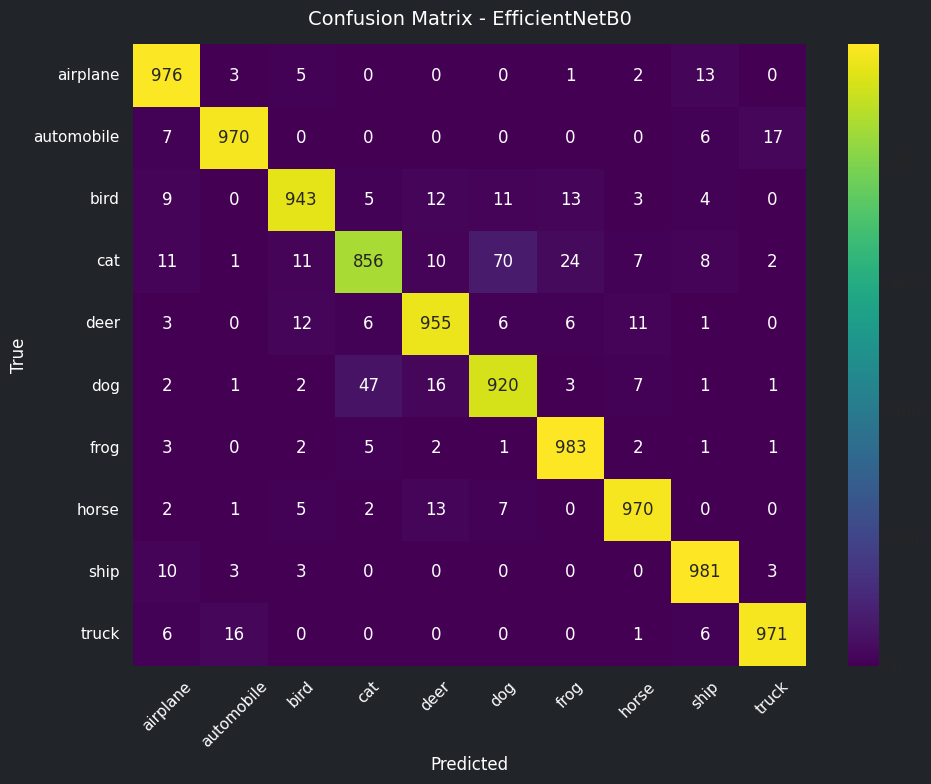

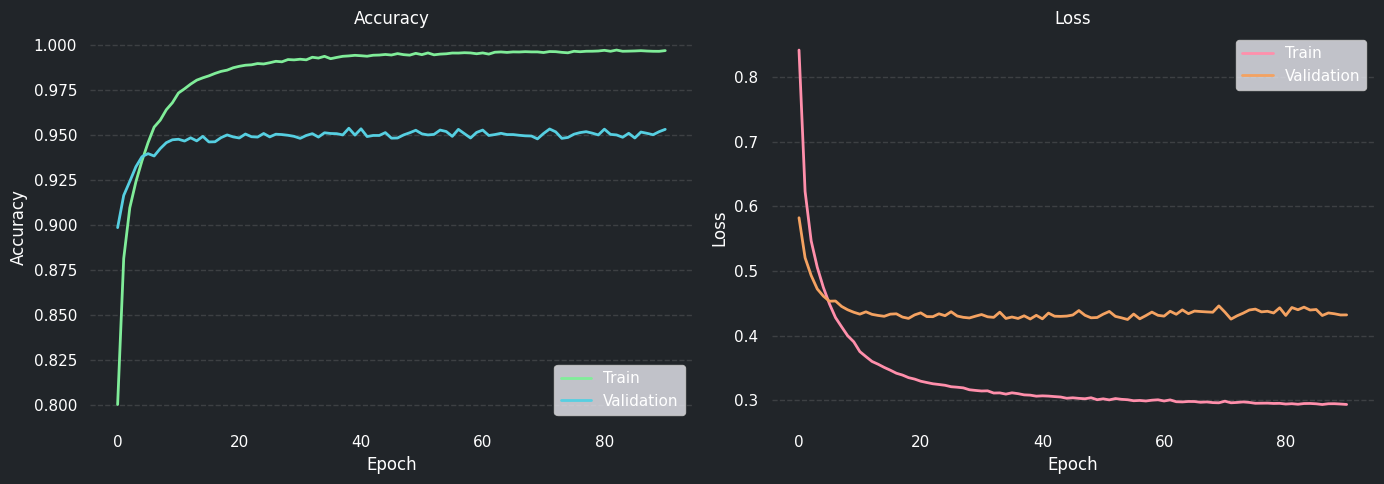

Saved curves to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/efficientnet_curves.png


In [10]:
# Detailed metrics, confusion matrix and learning curves via utils
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_true, y_pred = predict_and_resolve_labels(model=model, data=test_ds, labels=y_test, verbose=0)

print("Classification Report (Transfer Learning):")
print(build_classification_report(y_true, y_pred, target_names=class_names))

cm = compute_confusion_matrix(y_true, y_pred)
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix - EfficientNetB0',
    save_path=os.path.join(REPORTS_DIR, 'efficientnet_confusion.png'),
)

history_for_plot = history_stage2 if 'history_stage2' in globals() else history_stage1
plot_training_curves_notebook01(
    history=history_for_plot,
    save_path=os.path.join(REPORTS_DIR, 'efficientnet_curves.png'),
)
print("Saved curves to:", os.path.join(REPORTS_DIR, 'efficientnet_curves.png'))